# Pacotes

## Pacotes de variável de ambiente

## Pacotes gerais

In [1]:
import os
import sys

print(os.environ.get("SPARK_HOME"))
print(os.environ.get("HADOOP_HOME"))
print(os.environ.get("JAVA_HOME"))

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

C:\Users\pedro\Spark\spark-3.5.0-bin-hadoop3
C:\Users\pedro\hadoop\bin
C:\Program Files\Java\jdk1.8.0_202


In [2]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import lower, upper,row_number,isnan, when, count, col, coalesce, broadcast, regexp_replace, regexp_extract, lit
from pyspark.sql import functions as F, Window, Row
from pyspark.sql.functions import *
#from functools import reduce

In [3]:
#Pyspark
import py4j
from pyspark import SparkContext,SQLContext,SparkConf,StorageLevel

## Pacotes para configurar sessão no spark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
                            
## Pacote para localizar o path spark 
import findspark

In [4]:
# Pacote de geração de gráficos
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import missingno as msno #Pacote para ver dados missing
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Configuração do ambiente local do pyspark

In [5]:
findspark.init()

In [6]:
#SparkSession.builder.config(conf=SparkConf())
# Como configurar localmente:
# https://towardsdatascience.com/basics-of-apache-spark-configuration-settings-ca4faff40d45

In [7]:
spark = (SparkSession.builder
    .master("local[*]")
    .config("yarn.nodemanager.resource.memory-mb", "15g")
    .config("yarn.scheduler.maximum-allocation-mb", "15g")
    .config("yarn.scheduler.minimum-allocation-mb", "3g")
#    .config("yarn.nodemanager.resource.cpu-vcores", "12")
#    .config("yarn.scheduler.maximum-allocation-vcores", "2")
#    .config("yarn.scheduler.minimum-allocation-vcores", "12")
    .config("spark.driver.cores", "3")
    .config("spark.driver.memory", "6g")
    .config("spark.default.parallelism",'100')
    .config("spark.executor.cores", "2")
    .config("spark.executor.instances", "4")
    .config("spark.executor.memory",'3g')
    .config("spark.memory.fraction",'0.65')
    .config("spark.memory.storageFraction",'0.55')
    .config("spark.memory.offHeap.enabled",'true')
    .config("spark.memory.offHeap.size","3g")   
#    .config("spark.executor.memoryOverhead.size","")   
    .config('spark.sql.repl.eagerEval.enabled', True)
    .config("spark.sql.repl.eagerEval.maxNumRows",10)
    .appName('dataset_cnpj')
    .getOrCreate())

In [8]:
spark

# Carregando dados

In [9]:
df=spark.read.parquet("dados_tratados")

# Tratamento pontuais e filtros

In [10]:
df = df.filter(F.col('MUNICIPIO').isNotNull())
df = df.filter(F.col('MUNICIPIO') != 'null')

df = df.filter(F.col('CNAE').isNotNull())
df = df.filter(F.col('CNAE') != 'null')

In [11]:
df = df.filter(F.col('NAT_JURIDICA') == 'Empresário (Individual)')
df = df.select('CNPJ_BASICO','NOME_EMPRESA','NOME_FANTASIA','DT_SIT_CADASTRAL','SIT_CADASTRAL',"DT_INICIO_ATIVIDADE",'MOTIVO','MATRIZ_FILIAL','CNAE','PORTE','CAP_SOCIAL','PROVEDOR','MUNICIPIO','UF','CEP', 'QUALIFICACAO')

In [14]:
df = df.withColumn( "DT_INICIO_ATIVIDADE", F.to_date(F.col("DT_INICIO_ATIVIDADE").cast("string"), "yyyyMMdd"))
df = df.withColumn( "DT_SIT_CADASTRAL", F.to_date(F.col("DT_SIT_CADASTRAL").cast("string"), "yyyyMMdd"))



df = df.withColumn( "ano_cadastro", F.year('DT_INICIO_ATIVIDADE'))
df = df.withColumn( "mes_cadastro", F.month('DT_INICIO_ATIVIDADE'))

df = df.withColumn( "ano_sit_cadastral", F.year('DT_SIT_CADASTRAL'))
df = df.withColumn( "mes_sit_cadastral", F.month('DT_SIT_CADASTRAL'))

In [ ]:
%%time
df.summary()

In [ ]:
%%time
df.describe()

In [15]:
%%time
df_sit_cads = df.groupBy('SIT_CADASTRAL').count().orderBy(F.col('count').desc()).toPandas()

CPU times: total: 0 ns
Wall time: 5.73 s


In [31]:
fig = px.histogram(df_sit_cads,
             x = "SIT_CADASTRAL", 
             y='count',
             height = 400, width = 700,
             histnorm = 'percent')
fig.update_xaxes(title = "Stiuação Cadastral")
fig.update_yaxes(title = "Quantidade")
fig.update_layout(yaxis_ticksuffix = "%")
fig.update_layout(
    title={
        'text': "Situção Cadastral dos MEIs no Brasil",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20,
            'color': 'black'}})
py.plot(fig, filename = 'Count sit_cads', auto_open=False)
fig.write_html('situacao_cadastral.html')
#fig.show()

# Qual estado tem mais MEI? Quantidade de MEIs por estado

In [199]:
# API Plotly Chart Studio
username = ''
api_key = ''
chart_studio.tools.set_credentials_file (username = username, api_key = api_key)

In [18]:
%%time
df_uf = df.groupBy('UF','SIT_CADASTRAL').count().orderBy(F.col('count').desc()).toPandas()

CPU times: total: 0 ns
Wall time: 5.14 s


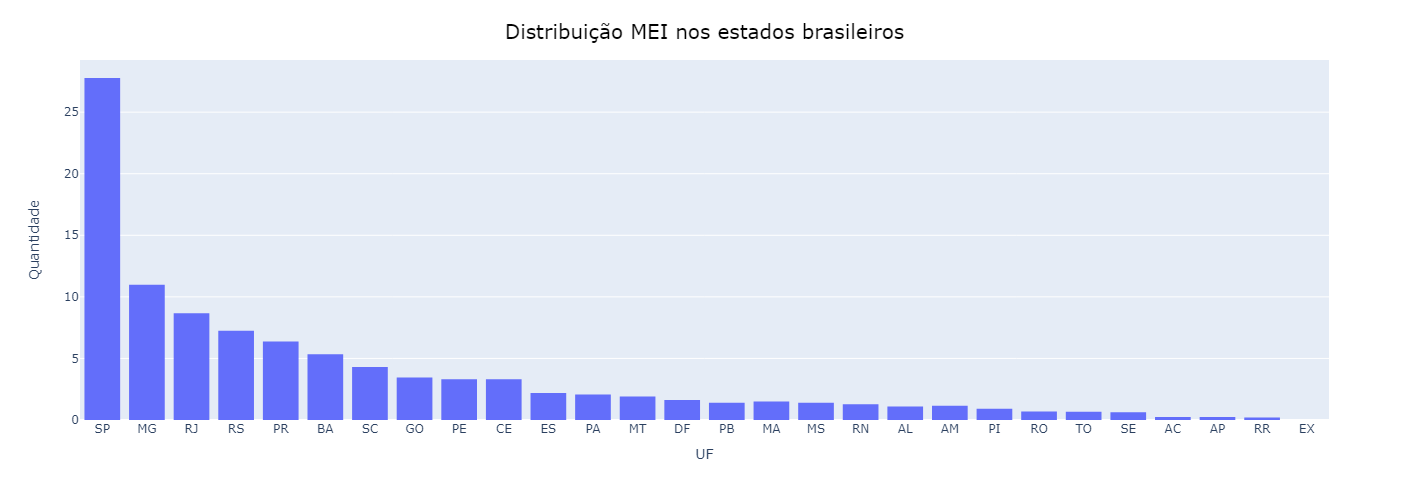

In [24]:
fig = px.histogram(df_uf,
             x = "UF", 
             y='count',
             height = 400, width = 700,
             histnorm = 'percent')
fig.update_xaxes(title = "UF")
fig.update_yaxes(title = "Quantidade")
#fig.show()
#py.plot(fig, filename = 'Count pnt', auto_open=True)
fig.update_layout(
    title={
        'text': "Distribuição MEI nos estados brasileiros",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20,
            'color': 'black'}})


In [44]:
fig = px.bar(df_uf,
             x = "UF", 
             y='count',
             color  = 'SIT_CADASTRAL',
             height = 500, width = 960)
fig.update_xaxes(title = "UF")
fig.update_yaxes(title = "Quantidade")
#fig.show()

fig.update_layout(
    title={
        'text': "Distribuição MEI nos estados brasileiros e sua situação cadastral",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20,
            'color': 'black'}})
py.plot(fig, filename = 'Count UF', auto_open=True)

'https://plotly.com/~mateusmoraesalmeida/1/'

# Quantos MEIs foram abertos por ano?

In [40]:
%%time
df_abertos = df.groupBy('ano_cadastro','MATRIZ_FILIAL').count().orderBy(F.col('ano_cadastro').desc()).toPandas()

CPU times: total: 0 ns
Wall time: 1min 19s


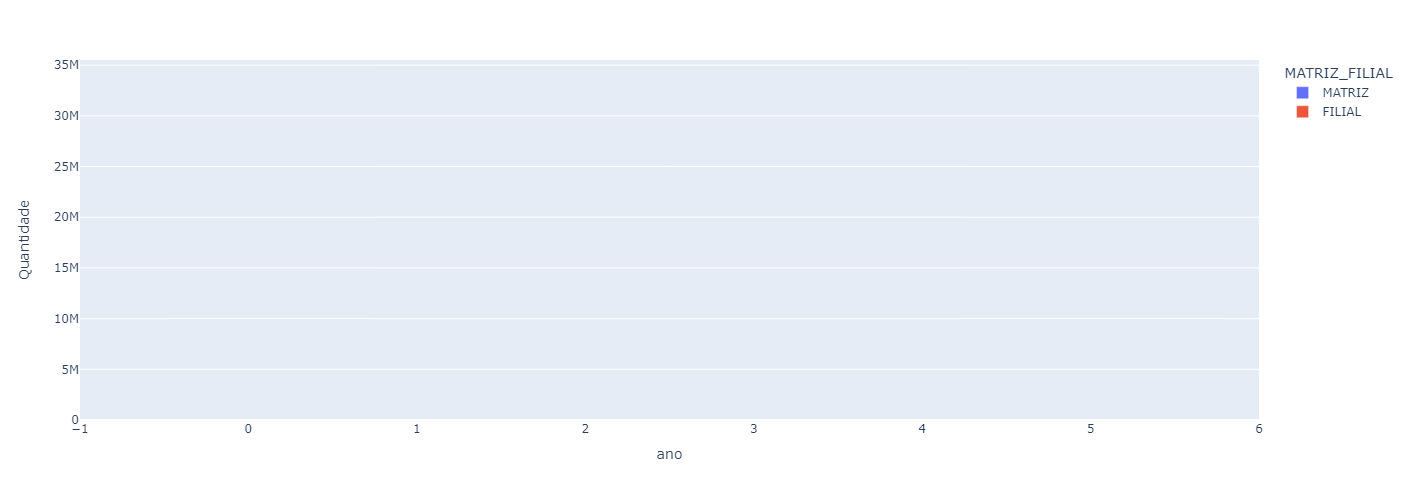

'https://plotly.com/~mateusmoraesalmeida/62/'

In [45]:
fig = px.bar(df_abertos,
             x = "ano_cadastro", 
             y='count',
             color  = 'MATRIZ_FILIAL',
             height = 500, width = 960)
fig.update_xaxes(title = "ano")
fig.update_yaxes(title = "Quantidade")
fig.show()
fig.update_layout(
    title={
        'text': "Origem ",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20,
            'color': 'black'}})
py.plot(fig, filename = 'Ano_cadastro', auto_open=False)

# MEI é só matriz ou tem filial?

In [105]:
%%time
df_abertos = df.groupBy('MATRIZ_FILIAL').count().orderBy(F.col('count').desc()).toPandas()

CPU times: total: 15.6 ms
Wall time: 5.28 s


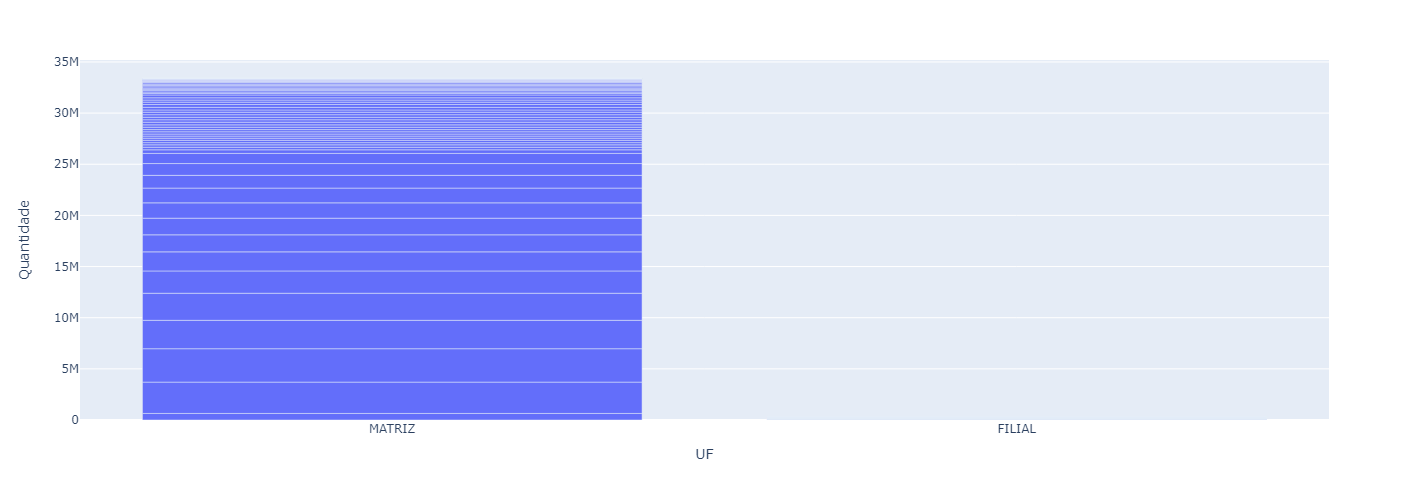

'https://plotly.com/~mateusmoraesalmeida/1/'

In [107]:
fig = px.bar(df_abertos,
             x = "MATRIZ_FILIAL", 
             y='count',
             height = 500, width = 960)
fig.update_xaxes(title = "UF")
fig.update_yaxes(title = "Quantidade")
fig.show()
py.plot(fig, filename = 'Count matriz_filial', auto_open=True)

# Quais são os 10 CNAEs mais cadastrados pelos MEIs

In [54]:
%%time
df_cnaes = df.groupBy('CNAE').count().orderBy(F.col('count').desc()).toPandas().head(10)

CPU times: total: 0 ns
Wall time: 4.41 s


In [39]:
fig = px.bar(df_cnaes,
             x = "CNAE", 
             y='count',
             height = 500, width = 960)
fig.update_xaxes(title = "CNAE")
fig.update_yaxes(title = "Quantidade")
#fig.show()
py.plot(fig, filename = 'Count cnaes', auto_open=True)

'https://plotly.com/~mateusmoraesalmeida/8/'

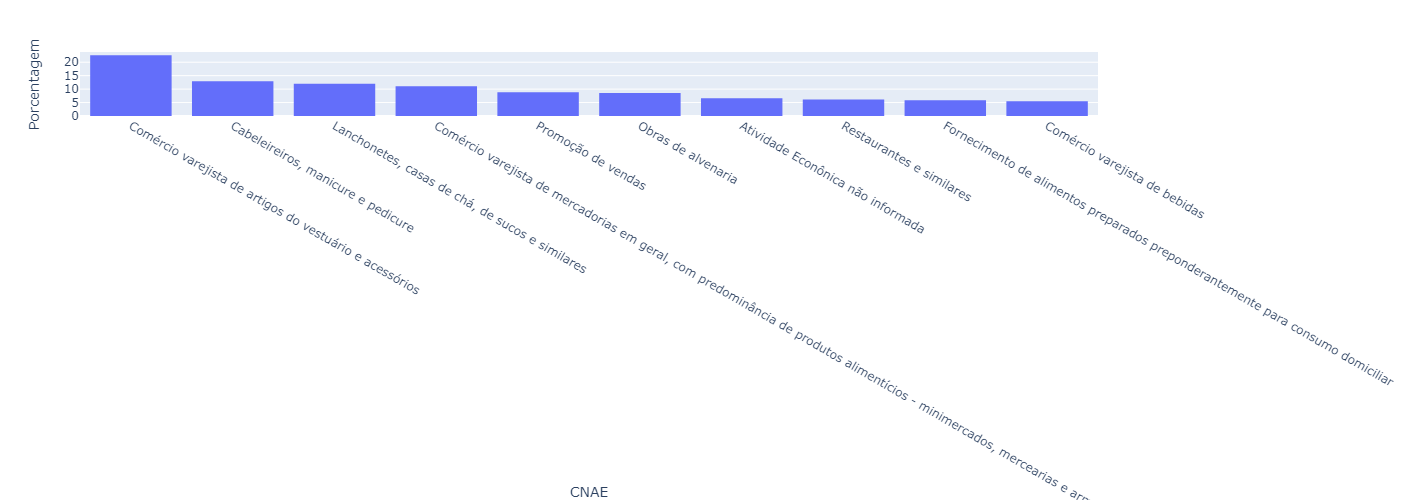

'https://plotly.com/~mateusmoraesalmeida/37/'

In [55]:
fig = px.histogram(df_cnaes,
             x = "CNAE", 
             y='count',
             height = 500, width = 960,
             histnorm = 'percent')
fig.update_xaxes(title = "CNAE")
fig.update_yaxes(title = "Porcentagem")
fig.show()
py.plot(fig, filename = 'Count cnae pnt', auto_open=True)

# Qual é o capital social da empresa de um MEI? (Média, mediana, distribuição)

In [57]:
df_cap_soc = df.filter((F.col('CAP_SOCIAL')>1)).select('CAP_SOCIAL').summary().toPandas()

In [58]:
%%time
quantiles = df.filter((F.col('CAP_SOCIAL')>1)).approxQuantile("CAP_SOCIAL", [0.05,0.10,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99], 0)

CPU times: total: 0 ns
Wall time: 1min 47s


In [59]:
df_cap_soc_mean = df.filter((F.col('CAP_SOCIAL')>1)&(F.col('CAP_SOCIAL')<100001)).select(mean('CAP_SOCIAL')).toPandas()
df_cap_soc_mean = df_cap_soc_mean.round()

In [ ]:
lista cnaes quartiles

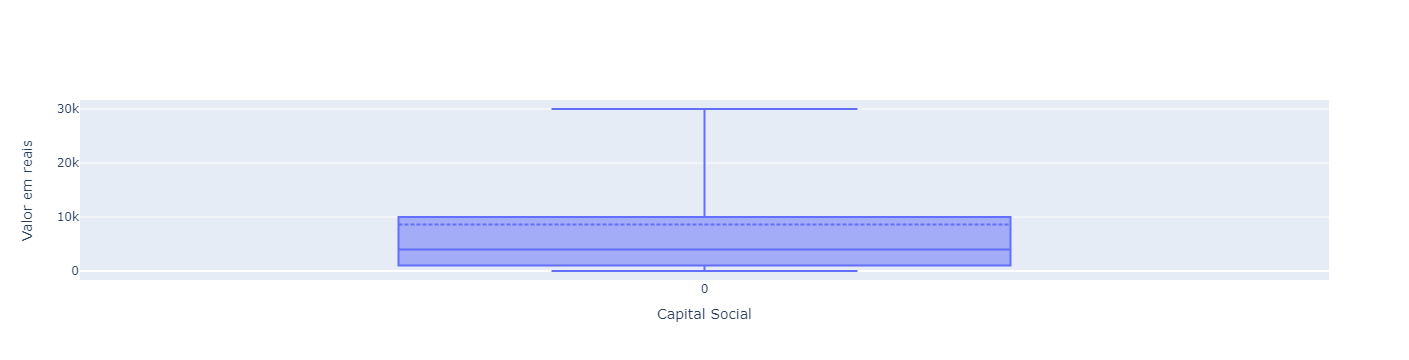

'https://plotly.com/~mateusmoraesalmeida/10/'

In [60]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Box(y=quantiles, orientation='v',boxmean=True, name='Capital Social'))

fig.update_traces(q1=quantiles[3:4], median=quantiles[6:7],
                  q3=quantiles[10:11],  upperfence=[30000],
                  lowerfence=[1], mean=[df_cap_soc_mean['avg(CAP_SOCIAL)'][0]])

fig.update_xaxes(title = "Capital Social")
fig.update_yaxes(title = "Valor em reais")
fig.show()

py.plot(fig, filename = 'box_cap_social', auto_open=True)

# Situação cadastral dos MEIs. Evolução da situação cadastral por ano.

In [25]:
%%time
df_sit_cad_ano = df.groupBy('ano_cadastro','SIT_CADASTRAL').count().orderBy(F.col('ano_cadastro').desc()).toPandas()

CPU times: total: 15.6 ms
Wall time: 10.6 s


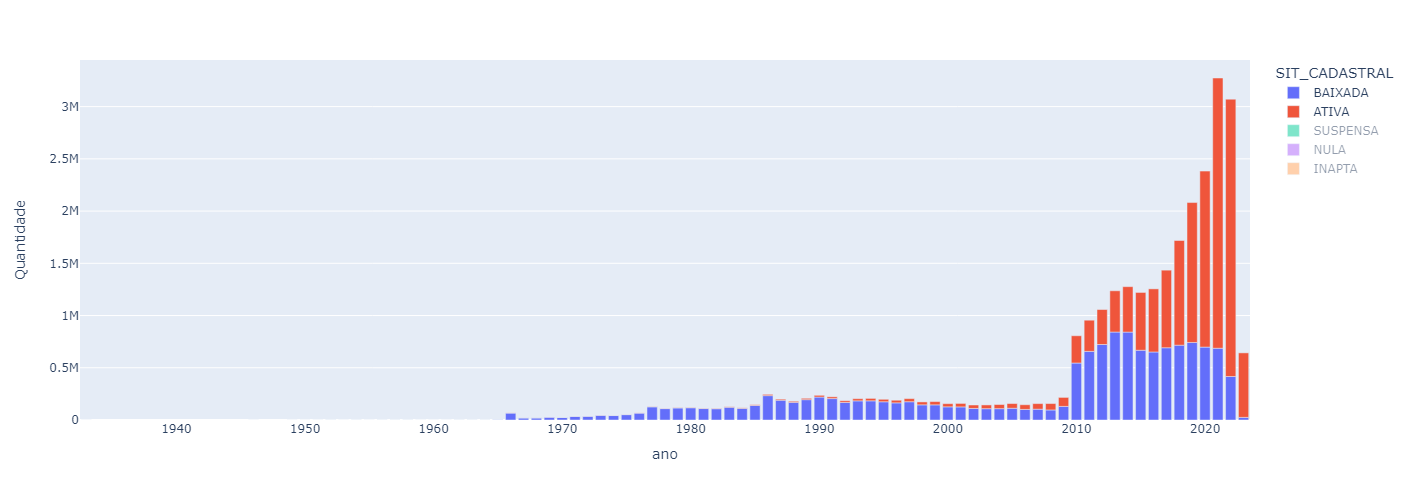

'https://plotly.com/~mateusmoraesalmeida/24/'

In [26]:
fig = px.bar(df_sit_cad_ano,
             x = "ano_cadastro", 
             y='count',
             color  = 'SIT_CADASTRAL',
             height = 500, width = 960)
fig.update_xaxes(title = "ano")
fig.update_yaxes(title = "Quantidade")
fig.show()
py.plot(fig, filename = 'Ano_sit_cadastro', auto_open=True)

# Quais são os 10 CNAEs com mais capital social e os 10 CNAEs com menos capital social?

In [45]:
%%time
df_cnaes_cap_soc2 =  df.filter((F.col('CAP_SOCIAL')>1)).groupBy('CNAE').agg(count("CNAE").alias("CNAE_count"), \
    avg("CAP_SOCIAL").alias("CAP_SOCIAL_avg"), min("CAP_SOCIAL").alias("min_quartil"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.05]).alias("quartil_05"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.10]).alias("quartil_10"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.15]).alias("quartil_15"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.20]).alias("quartil_20"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.25]).alias("quartil_25"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.30]).alias("quartil_30"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.35]).alias("quartil_35"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.40]).alias("quartil_40"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.45]).alias("quartil_45"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.50]).alias("quartil_50"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.55]).alias("quartil_55"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.60]).alias("quartil_60"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.65]).alias("quartil_65"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.70]).alias("quartil_70"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.75]).alias("quartil_75"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.80]).alias("quartil_80"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.85]).alias("quartil_85"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.90]).alias("quartil_90"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.95]).alias("quartil_95"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.99]).alias("quartil_99"),\
                                                                           max("CAP_SOCIAL").alias("max_cap_soc")).orderBy(F.col('CAP_SOCIAL_count').desc()).toPandas().head(10)

CPU times: total: 250 ms
Wall time: 14min 39s


In [55]:
df_cnaes_cap_soc2 = df_cnaes_cap_soc2.round()

In [83]:
def info_graf(lista_quart, lista_medidas, n_lista):
    lista_quartils = ['quartil_05', 'quartil_10','quartil_15', 'quartil_20',
                  'quartil_25', 'quartil_30','quartil_35', 'quartil_40',
                  'quartil_45', 'quartil_50','quartil_55', 'quartil_60',
                  'quartil_65', 'quartil_70','quartil_75', 'quartil_80',
                  'quartil_85', 'quartil_90', 'quartil_95']
    
    
    for i in range(len(lista_quartils)):
        quart_value = df_cnaes_cap_soc2[f'{lista_quartils[i]}'][n_lista][0]
        lista_quart.append(quart_value)
    
    min_value = df_cnaes_cap_soc2['min_quartil'][0]
    max_value = df_cnaes_cap_soc2['quartil_99'][n_lista][0]
    mean_value = df_cnaes_cap_soc2['CAP_SOCIAL_avg'][0]
    
    lista_medidas.append(min_value)
    lista_medidas.append(max_value)
    lista_medidas.append(mean_value)
    
    return lista_quart, lista_medidas

In [84]:
lista_cnae__quart_1 = []
lista_cnae_medidas_1 = []
lista_cnae__quart_2 = []
lista_cnae_medidas_2 = []
lista_cnae__quart_3 =  []
lista_cnae_medidas_3= []
lista_cnae__quart_4= []
lista_cnae_medidas_4= []
lista_cnae__quart_5 = []
lista_cnae_medidas_5 = []
lista_cnae__quart_6 = []
lista_cnae_medidas_6 = []
lista_cnae__quart_7 = []
lista_cnae_medidas_7= []
lista_cnae__quart_8= []
lista_cnae_medidas_8 = []
lista_cnae__quart_9 = []
lista_cnae_medidas_9 = []
lista_cnae__quart_10= []
lista_cnae_medidas_10 = []

In [85]:
lista_cnae__quart_1, lista_cnae_medidas_1 = info_graf(lista_cnae__quart_1, lista_cnae_medidas_1, 0)
lista_cnae__quart_2, lista_cnae_medidas_2 = info_graf(lista_cnae__quart_2, lista_cnae_medidas_2, 1)
lista_cnae__quart_3, lista_cnae_medidas_3 = info_graf(lista_cnae__quart_3, lista_cnae_medidas_3, 2)
lista_cnae__quart_4, lista_cnae_medidas_4 = info_graf(lista_cnae__quart_4, lista_cnae_medidas_4, 3)
lista_cnae__quart_5, lista_cnae_medidas_5 = info_graf(lista_cnae__quart_5, lista_cnae_medidas_5, 4)
lista_cnae__quart_6, lista_cnae_medidas_6 = info_graf(lista_cnae__quart_6, lista_cnae_medidas_6, 5)
lista_cnae__quart_7, lista_cnae_medidas_7 = info_graf(lista_cnae__quart_7, lista_cnae_medidas_7, 6)
lista_cnae__quart_8, lista_cnae_medidas_8 = info_graf(lista_cnae__quart_8, lista_cnae_medidas_8, 7)
lista_cnae__quart_9, lista_cnae_medidas_9 = info_graf(lista_cnae__quart_9, lista_cnae_medidas_9, 8)
lista_cnae__quart_10, lista_cnae_medidas_10 = info_graf(lista_cnae__quart_10, lista_cnae_medidas_10, 9)

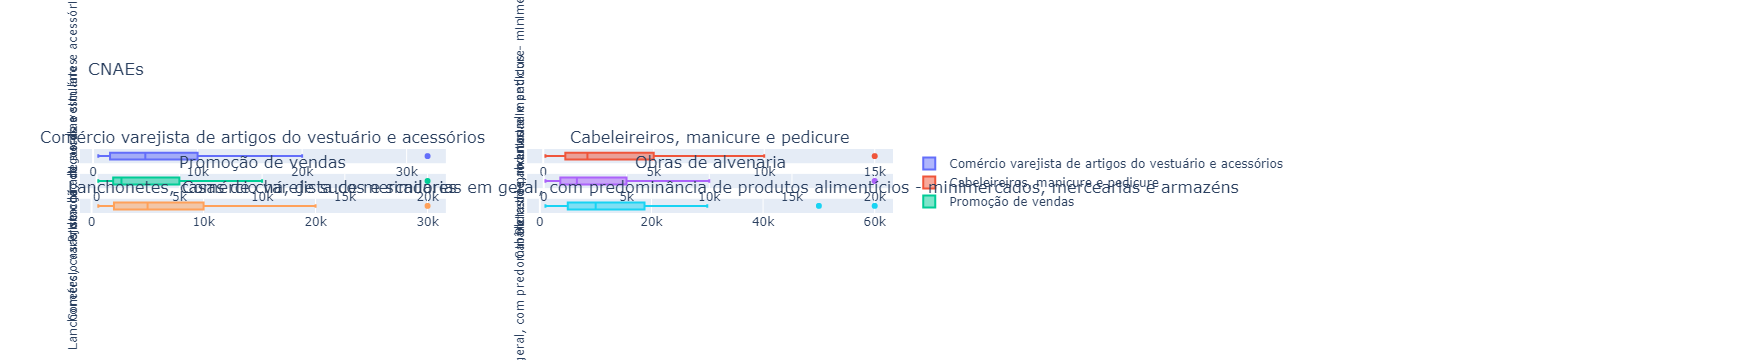

'https://plotly.com/~mateusmoraesalmeida/41/'

In [151]:
#fig = go.Figure()
fig = make_subplots(rows=3, cols=2, subplot_titles=[df_cnaes_cap_soc2['CNAE'][0], df_cnaes_cap_soc2['CNAE'][1],
                                                    df_cnaes_cap_soc2['CNAE'][2], df_cnaes_cap_soc2['CNAE'][3], 
                                                    df_cnaes_cap_soc2['CNAE'][4], df_cnaes_cap_soc2['CNAE'][5]])



b1 = go.Box(x=lista_cnae__quart_1, orientation='h', name=df_cnaes_cap_soc2['CNAE'][0])
fig.update_traces(q1=[lista_cnae__quart_1[4]], median=[lista_cnae__quart_1[9]],
                  q3=[lista_cnae__quart_1[14]],  upperfence=[lista_cnae_medidas_1[1]],
                  lowerfence=[lista_cnae_medidas_1[0]], mean=[lista_cnae_medidas_1[2]])
fig.update_yaxes(tickangle=270)



b2 = go.Box(x=lista_cnae__quart_2, orientation='h', name=df_cnaes_cap_soc2['CNAE'][1])
fig.update_traces(q1=[lista_cnae__quart_2[4]], median=[lista_cnae__quart_2[9]],
                  q3=[lista_cnae__quart_2[14]],  upperfence=[lista_cnae_medidas_2[1]],
                  lowerfence=[lista_cnae_medidas_2[0]], mean=[lista_cnae_medidas_2[2]])

b3 = go.Box(x=lista_cnae__quart_3, orientation='h', name=df_cnaes_cap_soc2['CNAE'][2])
fig.update_traces(q1=[lista_cnae__quart_3[4]], median=[lista_cnae__quart_3[9]],
                  q3=[lista_cnae__quart_3[14]],  upperfence=[lista_cnae_medidas_3[1]],
                  lowerfence=[lista_cnae_medidas_3[0]], mean=[lista_cnae_medidas_3[2]])



b4 = go.Box(x=lista_cnae__quart_4, orientation='h', name=df_cnaes_cap_soc2['CNAE'][3])
fig.update_traces(q1=[lista_cnae__quart_4[4]], median=[lista_cnae__quart_4[9]],
                  q3=[lista_cnae__quart_4[14]],  upperfence=[lista_cnae_medidas_4[1]],
                  lowerfence=[lista_cnae_medidas_4[0]], mean=[lista_cnae_medidas_4[2]])



b5 = go.Box(x=lista_cnae__quart_5, orientation='h', name=df_cnaes_cap_soc2['CNAE'][4])
fig.update_traces(q1=[lista_cnae__quart_5[4]], median=[lista_cnae__quart_5[9]],
                  q3=[lista_cnae__quart_5[14]],  upperfence=[lista_cnae_medidas_5[1]],
                  lowerfence=[lista_cnae_medidas_5[0]], mean=[lista_cnae_medidas_5[2]])



b6 = go.Box(x=lista_cnae__quart_6, orientation='h', name=df_cnaes_cap_soc2['CNAE'][5])
fig.update_traces(q1=[lista_cnae__quart_6[4]], median=[lista_cnae__quart_6[9]],
                  q3=[lista_cnae__quart_6[14]],  upperfence=[lista_cnae_medidas_6[1]],
                  lowerfence=[lista_cnae_medidas_4[0]], mean=[lista_cnae_medidas_6[2]])


fig.add_traces(b1, 1, 1)
fig.add_traces(b2, 1, 2)
fig.add_traces(b3, 2, 1)
fig.add_traces(b4, 2, 2)
fig.add_traces(b5, 3, 1)
fig.add_traces(b6, 3, 2)


fig.update_layout( title='CNAEs')

fig.show()

py.plot(fig, filename = 'cnae_ind_plot_1', auto_open=True)

#  Quais os provedores de e-mail mais utilizados para cadastrar o MEI na receita federal?

In [161]:
%%time
df_motivo = df.filter((F.col('SIT_CADASTRAL')!='BAIXADA') & (F.col('MOTIVO')!='SEM MOTIVO') ).groupBy('MOTIVO').count().orderBy(F.col('count').desc()).toPandas()

CPU times: total: 15.6 ms
Wall time: 3 s


In [162]:
df_motivo

,MOTIVO,count
0,OMISSAO DE DECLARACOES,5229239
1,PEDIDO DE BAIXA INDEFERIDA,53060
2,ANULACAO POR NAO CONFIRMADO ATO DE REGISTRO DO...,40839
3,ANULACAO POR VICIOS,18175
4,INTERRUPCAO TEMPORARIA DAS ATIVIDADES,8946
5,INCONSISTENCIA CADASTRAL,6857
6,BAIXA INICIADA EM ANALISE,4534
7,ANULACAO POR MULTICIPLIDADE,3933
8,ANULACAO DE INSCRICAO INDEVIDA,2212
9,INEXISTENCIA DE FATO,421


In [157]:
df_cap_his = df.filter((F.col('CAP_SOCIAL')>1)&(F.col('CAP_SOCIAL')<150001)).select('CAP_SOCIAL').toPandas()

In [169]:
import plotly.express as px

fig = px.histogram(df_cap_his, x="CAP_SOCIAL", nbins=20,
                   marginal="box", # or violin, rug
                   hover_data=df_cap_his.columns)
fig.show()

In [ ]:
fig = px.histogram(df_sit_cads,
             x = "SIT_CADASTRAL", 
             y='count',
             height = 500, width = 960,
             histnorm = 'percent')

In [170]:
df_cap_his.describe() 

,CAP_SOCIAL
count,2.390913e+07
mean,8.985578e+03
std,1.605630e+04
min,1.010000e+00
25%,1.000000e+03
50%,4.000000e+03
75%,1.000000e+04
max,1.500010e+05


# Quais os principais motivos dos MEIs que foram dados baixa (situação cadastral)?
	


#  Qual é o capital social dos principais MEIs que deram baixa?
	


#  Podemos pegar os dados de renda per capta por município e cruzar com o valor médio do capital social de cada MEI. Ou ver se existe correlação entre renda per capita e quantidade de MEIs

# Quais são os 10 CNAEs com mais capital social e os 10 CNAEs com menos capital social?

In [15]:
%%time
df_motivo_cap_soc =  df.filter((F.col('CAP_SOCIAL')>1) & (F.col('SIT_CADASTRAL') == 'BAIXADA')).groupBy('MOTIVO').agg(count("MOTIVO").alias("MOTIVO_count"), \
    avg("CAP_SOCIAL").alias("CAP_SOCIAL_avg"), min("CAP_SOCIAL").alias("min_quartil"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.05]).alias("quartil_05"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.10]).alias("quartil_10"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.15]).alias("quartil_15"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.20]).alias("quartil_20"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.25]).alias("quartil_25"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.30]).alias("quartil_30"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.35]).alias("quartil_35"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.40]).alias("quartil_40"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.45]).alias("quartil_45"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.50]).alias("quartil_50"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.55]).alias("quartil_55"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.60]).alias("quartil_60"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.65]).alias("quartil_65"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.70]).alias("quartil_70"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.75]).alias("quartil_75"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.80]).alias("quartil_80"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.85]).alias("quartil_85"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.90]).alias("quartil_90"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.95]).alias("quartil_95"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.99]).alias("quartil_99"),\
                                                                           max("CAP_SOCIAL").alias("max_cap_soc")).orderBy(F.col('MOTIVO_count').desc()).toPandas().head(10)

df_motivo_cap_soc = df_motivo_cap_soc.round()

CPU times: total: 46.9 ms
Wall time: 1min 23s


In [83]:
def info_graf(lista_quart, lista_medidas, n_lista):
    lista_quartils = ['quartil_05', 'quartil_10','quartil_15', 'quartil_20',
                  'quartil_25', 'quartil_30','quartil_35', 'quartil_40',
                  'quartil_45', 'quartil_50','quartil_55', 'quartil_60',
                  'quartil_65', 'quartil_70','quartil_75', 'quartil_80',
                  'quartil_85', 'quartil_90', 'quartil_95']
    
    
    for i in range(len(lista_quartils)):
        quart_value = df_cnaes_cap_soc2[f'{lista_quartils[i]}'][n_lista][0]
        lista_quart.append(quart_value)
    
    min_value = df_cnaes_cap_soc2['min_quartil'][0]
    max_value = df_cnaes_cap_soc2['quartil_99'][n_lista][0]
    mean_value = df_cnaes_cap_soc2['CAP_SOCIAL_avg'][0]
    
    lista_medidas.append(min_value)
    lista_medidas.append(max_value)
    lista_medidas.append(mean_value)
    
    return lista_quart, lista_medidas

In [84]:
lista_cnae__quart_1 = []
lista_cnae_medidas_1 = []
lista_cnae__quart_2 = []
lista_cnae_medidas_2 = []
lista_cnae__quart_3 =  []
lista_cnae_medidas_3= []
lista_cnae__quart_4= []
lista_cnae_medidas_4= []
lista_cnae__quart_5 = []
lista_cnae_medidas_5 = []
lista_cnae__quart_6 = []
lista_cnae_medidas_6 = []
lista_cnae__quart_7 = []
lista_cnae_medidas_7= []
lista_cnae__quart_8= []
lista_cnae_medidas_8 = []
lista_cnae__quart_9 = []
lista_cnae_medidas_9 = []
lista_cnae__quart_10= []
lista_cnae_medidas_10 = []

In [85]:
lista_cnae__quart_1, lista_cnae_medidas_1 = info_graf(lista_cnae__quart_1, lista_cnae_medidas_1, 0)
lista_cnae__quart_2, lista_cnae_medidas_2 = info_graf(lista_cnae__quart_2, lista_cnae_medidas_2, 1)
lista_cnae__quart_3, lista_cnae_medidas_3 = info_graf(lista_cnae__quart_3, lista_cnae_medidas_3, 2)
lista_cnae__quart_4, lista_cnae_medidas_4 = info_graf(lista_cnae__quart_4, lista_cnae_medidas_4, 3)
lista_cnae__quart_5, lista_cnae_medidas_5 = info_graf(lista_cnae__quart_5, lista_cnae_medidas_5, 4)
lista_cnae__quart_6, lista_cnae_medidas_6 = info_graf(lista_cnae__quart_6, lista_cnae_medidas_6, 5)
lista_cnae__quart_7, lista_cnae_medidas_7 = info_graf(lista_cnae__quart_7, lista_cnae_medidas_7, 6)
lista_cnae__quart_8, lista_cnae_medidas_8 = info_graf(lista_cnae__quart_8, lista_cnae_medidas_8, 7)
lista_cnae__quart_9, lista_cnae_medidas_9 = info_graf(lista_cnae__quart_9, lista_cnae_medidas_9, 8)
lista_cnae__quart_10, lista_cnae_medidas_10 = info_graf(lista_cnae__quart_10, lista_cnae_medidas_10, 9)

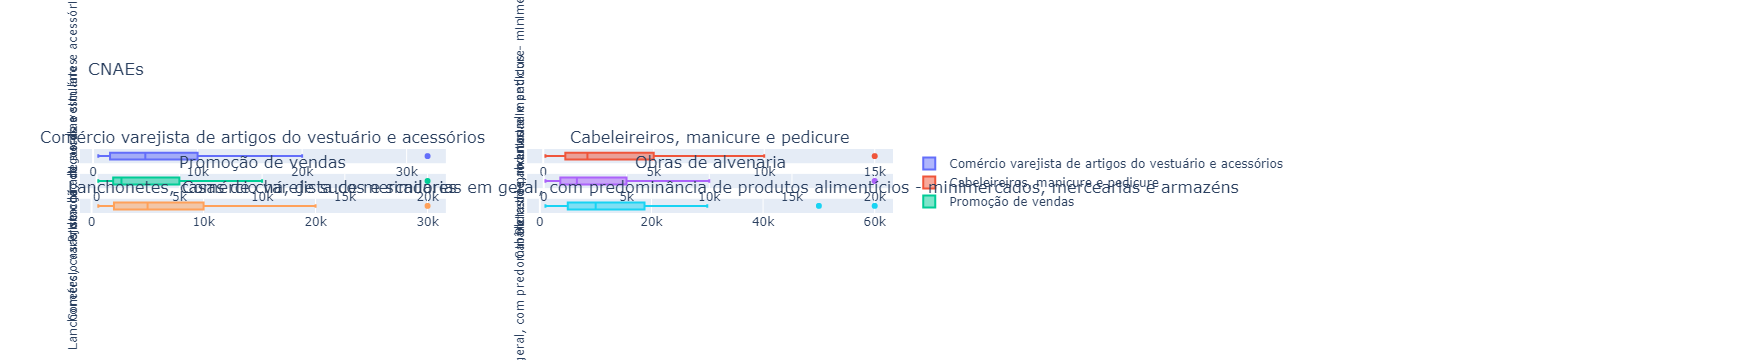

'https://plotly.com/~mateusmoraesalmeida/41/'

In [151]:
#fig = go.Figure()
fig = make_subplots(rows=3, cols=2, subplot_titles=[df_cnaes_cap_soc2['CNAE'][0], df_cnaes_cap_soc2['CNAE'][1],
                                                    df_cnaes_cap_soc2['CNAE'][2], df_cnaes_cap_soc2['CNAE'][3], 
                                                    df_cnaes_cap_soc2['CNAE'][4], df_cnaes_cap_soc2['CNAE'][5]])



b1 = go.Box(x=lista_cnae__quart_1, orientation='h', name=df_cnaes_cap_soc2['CNAE'][0])
fig.update_traces(q1=[lista_cnae__quart_1[4]], median=[lista_cnae__quart_1[9]],
                  q3=[lista_cnae__quart_1[14]],  upperfence=[lista_cnae_medidas_1[1]],
                  lowerfence=[lista_cnae_medidas_1[0]], mean=[lista_cnae_medidas_1[2]])
fig.update_yaxes(tickangle=270)



b2 = go.Box(x=lista_cnae__quart_2, orientation='h', name=df_cnaes_cap_soc2['CNAE'][1])
fig.update_traces(q1=[lista_cnae__quart_2[4]], median=[lista_cnae__quart_2[9]],
                  q3=[lista_cnae__quart_2[14]],  upperfence=[lista_cnae_medidas_2[1]],
                  lowerfence=[lista_cnae_medidas_2[0]], mean=[lista_cnae_medidas_2[2]])

b3 = go.Box(x=lista_cnae__quart_3, orientation='h', name=df_cnaes_cap_soc2['CNAE'][2])
fig.update_traces(q1=[lista_cnae__quart_3[4]], median=[lista_cnae__quart_3[9]],
                  q3=[lista_cnae__quart_3[14]],  upperfence=[lista_cnae_medidas_3[1]],
                  lowerfence=[lista_cnae_medidas_3[0]], mean=[lista_cnae_medidas_3[2]])



b4 = go.Box(x=lista_cnae__quart_4, orientation='h', name=df_cnaes_cap_soc2['CNAE'][3])
fig.update_traces(q1=[lista_cnae__quart_4[4]], median=[lista_cnae__quart_4[9]],
                  q3=[lista_cnae__quart_4[14]],  upperfence=[lista_cnae_medidas_4[1]],
                  lowerfence=[lista_cnae_medidas_4[0]], mean=[lista_cnae_medidas_4[2]])



b5 = go.Box(x=lista_cnae__quart_5, orientation='h', name=df_cnaes_cap_soc2['CNAE'][4])
fig.update_traces(q1=[lista_cnae__quart_5[4]], median=[lista_cnae__quart_5[9]],
                  q3=[lista_cnae__quart_5[14]],  upperfence=[lista_cnae_medidas_5[1]],
                  lowerfence=[lista_cnae_medidas_5[0]], mean=[lista_cnae_medidas_5[2]])



b6 = go.Box(x=lista_cnae__quart_6, orientation='h', name=df_cnaes_cap_soc2['CNAE'][5])
fig.update_traces(q1=[lista_cnae__quart_6[4]], median=[lista_cnae__quart_6[9]],
                  q3=[lista_cnae__quart_6[14]],  upperfence=[lista_cnae_medidas_6[1]],
                  lowerfence=[lista_cnae_medidas_4[0]], mean=[lista_cnae_medidas_6[2]])


fig.add_traces(b1, 1, 1)
fig.add_traces(b2, 1, 2)
fig.add_traces(b3, 2, 1)
fig.add_traces(b4, 2, 2)
fig.add_traces(b5, 3, 1)
fig.add_traces(b6, 3, 2)


fig.update_layout( title='CNAEs')

fig.show()

py.plot(fig, filename = 'cnae_ind_plot_1', auto_open=True)

# Quais são os 10 CNAEs com mais capital social e os 10 CNAEs com menos capital social?

In [15]:
%%time
df_motivo_cap_soc =  df.filter((F.col('CAP_SOCIAL')>1)).groupBy('SIT_CADASTRAL').agg(count("MOTIVO").alias("MOTIVO_count"), \
    avg("CAP_SOCIAL").alias("CAP_SOCIAL_avg"), min("CAP_SOCIAL").alias("min_quartil"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.05]).alias("quartil_05"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.10]).alias("quartil_10"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.15]).alias("quartil_15"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.20]).alias("quartil_20"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.25]).alias("quartil_25"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.30]).alias("quartil_30"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.35]).alias("quartil_35"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.40]).alias("quartil_40"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.45]).alias("quartil_45"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.50]).alias("quartil_50"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.55]).alias("quartil_55"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.60]).alias("quartil_60"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.65]).alias("quartil_65"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.70]).alias("quartil_70"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.75]).alias("quartil_75"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.80]).alias("quartil_80"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.85]).alias("quartil_85"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.90]).alias("quartil_90"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.95]).alias("quartil_95"),\
                                                                           percentile_approx("CAP_SOCIAL", [0.99]).alias("quartil_99"),\
                                                                           max("CAP_SOCIAL").alias("max_cap_soc")).orderBy(F.col('MOTIVO_count').desc()).toPandas().head(10)

df_motivo_cap_soc = df_motivo_cap_soc.round()

CPU times: total: 46.9 ms
Wall time: 1min 23s


In [83]:
def info_graf(lista_quart, lista_medidas, n_lista):
    lista_quartils = ['quartil_05', 'quartil_10','quartil_15', 'quartil_20',
                  'quartil_25', 'quartil_30','quartil_35', 'quartil_40',
                  'quartil_45', 'quartil_50','quartil_55', 'quartil_60',
                  'quartil_65', 'quartil_70','quartil_75', 'quartil_80',
                  'quartil_85', 'quartil_90', 'quartil_95']
    
    
    for i in range(len(lista_quartils)):
        quart_value = df_cnaes_cap_soc2[f'{lista_quartils[i]}'][n_lista][0]
        lista_quart.append(quart_value)
    
    min_value = df_cnaes_cap_soc2['min_quartil'][0]
    max_value = df_cnaes_cap_soc2['quartil_99'][n_lista][0]
    mean_value = df_cnaes_cap_soc2['CAP_SOCIAL_avg'][0]
    
    lista_medidas.append(min_value)
    lista_medidas.append(max_value)
    lista_medidas.append(mean_value)
    
    return lista_quart, lista_medidas

In [84]:
lista_cnae__quart_1 = []
lista_cnae_medidas_1 = []
lista_cnae__quart_2 = []
lista_cnae_medidas_2 = []
lista_cnae__quart_3 =  []
lista_cnae_medidas_3= []
lista_cnae__quart_4= []
lista_cnae_medidas_4= []
lista_cnae__quart_5 = []
lista_cnae_medidas_5 = []
lista_cnae__quart_6 = []
lista_cnae_medidas_6 = []
lista_cnae__quart_7 = []
lista_cnae_medidas_7= []
lista_cnae__quart_8= []
lista_cnae_medidas_8 = []
lista_cnae__quart_9 = []
lista_cnae_medidas_9 = []
lista_cnae__quart_10= []
lista_cnae_medidas_10 = []

In [85]:
lista_cnae__quart_1, lista_cnae_medidas_1 = info_graf(lista_cnae__quart_1, lista_cnae_medidas_1, 0)
lista_cnae__quart_2, lista_cnae_medidas_2 = info_graf(lista_cnae__quart_2, lista_cnae_medidas_2, 1)
lista_cnae__quart_3, lista_cnae_medidas_3 = info_graf(lista_cnae__quart_3, lista_cnae_medidas_3, 2)
lista_cnae__quart_4, lista_cnae_medidas_4 = info_graf(lista_cnae__quart_4, lista_cnae_medidas_4, 3)
lista_cnae__quart_5, lista_cnae_medidas_5 = info_graf(lista_cnae__quart_5, lista_cnae_medidas_5, 4)
lista_cnae__quart_6, lista_cnae_medidas_6 = info_graf(lista_cnae__quart_6, lista_cnae_medidas_6, 5)
lista_cnae__quart_7, lista_cnae_medidas_7 = info_graf(lista_cnae__quart_7, lista_cnae_medidas_7, 6)
lista_cnae__quart_8, lista_cnae_medidas_8 = info_graf(lista_cnae__quart_8, lista_cnae_medidas_8, 7)
lista_cnae__quart_9, lista_cnae_medidas_9 = info_graf(lista_cnae__quart_9, lista_cnae_medidas_9, 8)
lista_cnae__quart_10, lista_cnae_medidas_10 = info_graf(lista_cnae__quart_10, lista_cnae_medidas_10, 9)

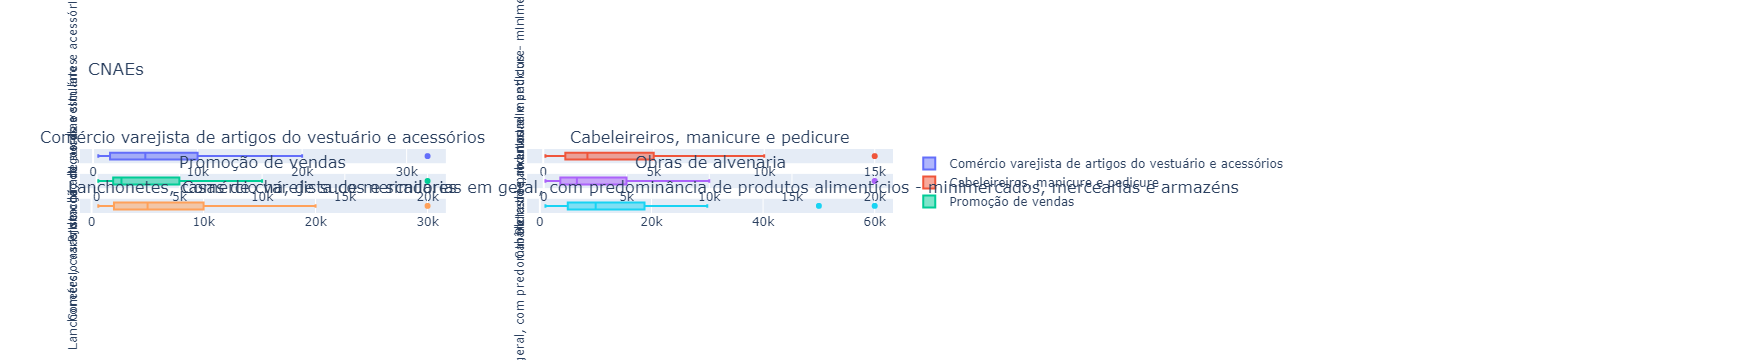

'https://plotly.com/~mateusmoraesalmeida/41/'

In [151]:
#fig = go.Figure()
fig = make_subplots(rows=3, cols=2, subplot_titles=[df_cnaes_cap_soc2['CNAE'][0], df_cnaes_cap_soc2['CNAE'][1],
                                                    df_cnaes_cap_soc2['CNAE'][2], df_cnaes_cap_soc2['CNAE'][3], 
                                                    df_cnaes_cap_soc2['CNAE'][4], df_cnaes_cap_soc2['CNAE'][5]])



b1 = go.Box(x=lista_cnae__quart_1, orientation='h', name=df_cnaes_cap_soc2['CNAE'][0])
fig.update_traces(q1=[lista_cnae__quart_1[4]], median=[lista_cnae__quart_1[9]],
                  q3=[lista_cnae__quart_1[14]],  upperfence=[lista_cnae_medidas_1[1]],
                  lowerfence=[lista_cnae_medidas_1[0]], mean=[lista_cnae_medidas_1[2]])
fig.update_yaxes(tickangle=270)



b2 = go.Box(x=lista_cnae__quart_2, orientation='h', name=df_cnaes_cap_soc2['CNAE'][1])
fig.update_traces(q1=[lista_cnae__quart_2[4]], median=[lista_cnae__quart_2[9]],
                  q3=[lista_cnae__quart_2[14]],  upperfence=[lista_cnae_medidas_2[1]],
                  lowerfence=[lista_cnae_medidas_2[0]], mean=[lista_cnae_medidas_2[2]])

b3 = go.Box(x=lista_cnae__quart_3, orientation='h', name=df_cnaes_cap_soc2['CNAE'][2])
fig.update_traces(q1=[lista_cnae__quart_3[4]], median=[lista_cnae__quart_3[9]],
                  q3=[lista_cnae__quart_3[14]],  upperfence=[lista_cnae_medidas_3[1]],
                  lowerfence=[lista_cnae_medidas_3[0]], mean=[lista_cnae_medidas_3[2]])



b4 = go.Box(x=lista_cnae__quart_4, orientation='h', name=df_cnaes_cap_soc2['CNAE'][3])
fig.update_traces(q1=[lista_cnae__quart_4[4]], median=[lista_cnae__quart_4[9]],
                  q3=[lista_cnae__quart_4[14]],  upperfence=[lista_cnae_medidas_4[1]],
                  lowerfence=[lista_cnae_medidas_4[0]], mean=[lista_cnae_medidas_4[2]])



b5 = go.Box(x=lista_cnae__quart_5, orientation='h', name=df_cnaes_cap_soc2['CNAE'][4])
fig.update_traces(q1=[lista_cnae__quart_5[4]], median=[lista_cnae__quart_5[9]],
                  q3=[lista_cnae__quart_5[14]],  upperfence=[lista_cnae_medidas_5[1]],
                  lowerfence=[lista_cnae_medidas_5[0]], mean=[lista_cnae_medidas_5[2]])



b6 = go.Box(x=lista_cnae__quart_6, orientation='h', name=df_cnaes_cap_soc2['CNAE'][5])
fig.update_traces(q1=[lista_cnae__quart_6[4]], median=[lista_cnae__quart_6[9]],
                  q3=[lista_cnae__quart_6[14]],  upperfence=[lista_cnae_medidas_6[1]],
                  lowerfence=[lista_cnae_medidas_4[0]], mean=[lista_cnae_medidas_6[2]])


fig.add_traces(b1, 1, 1)
fig.add_traces(b2, 1, 2)
fig.add_traces(b3, 2, 1)
fig.add_traces(b4, 2, 2)
fig.add_traces(b5, 3, 1)
fig.add_traces(b6, 3, 2)


fig.update_layout( title='CNAEs')

fig.show()

py.plot(fig, filename = 'cnae_ind_plot_1', auto_open=True)

# propo

In [20]:
import pandas as pd

In [17]:
df_uf2 = df.groupBy('UF').count().orderBy(F.col('count').desc()).toPandas()

In [24]:
df_pop_est = pd.read_csv('Pop_estados.csv', sep=';')

In [29]:
df_pop_est = df_pop_est.rename(columns={'Sigla':'UF'})

In [37]:
df_join_pop = df_uf2.set_index('UF').join(df_pop_est.set_index('UF'), on=['UF'], how='left')

df_join_pop['proporcao'] = ((df_join_pop['count']/df_join_pop['Pop'])*100).round(2)

df_join_pop = df_join_pop.dropna()

df_join_pop =  df_join_pop.reset_index()

In [53]:
df_join_pop =  df_join_pop.sort_values(by=['proporcao'], ascending=False)

In [57]:
df_uf = df.groupBy('UF').count().orderBy(F.col('count').desc()).toPandas()

In [65]:
df_uf = df_uf[0:27]

In [77]:
df_uf = df_uf[['UF','pcnt_base']]

In [78]:
df_join_pop = df_join_pop.set_index('UF').join(df_uf.set_index('UF'), on=['UF'], how='left').reset_index()

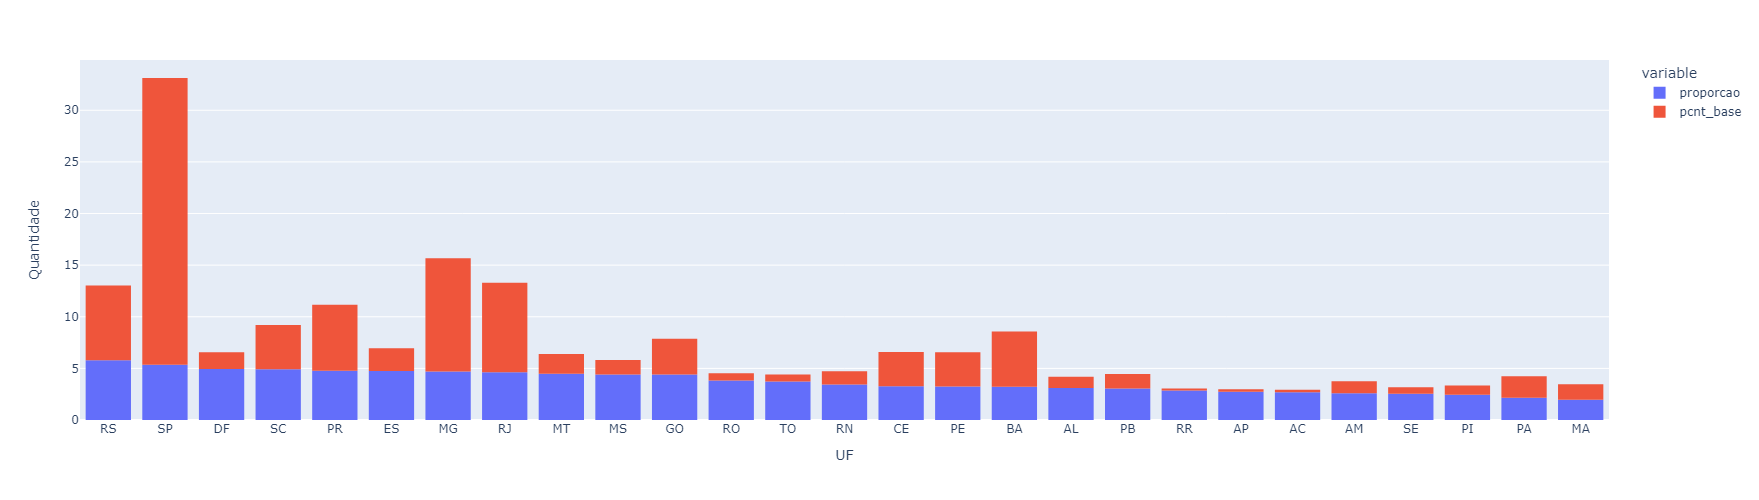

In [81]:
fig = px.histogram(df_join_pop,
             x = "UF", 
             y=['proporcao','pcnt_base'],
             height = 500, width = 960,
             histnorm = 'percent')
fig.update_xaxes(title = "UF")
fig.update_yaxes(title = "Quantidade")
#fig.show()
#py.plot(fig, filename = 'Count pnt', auto_open=True)

In [79]:
df_join_pop

,UF,count,Pop,proporcao,pcnt_base
0,RS,2443314,11088065.0,22.04,7.24
1,SP,9369451,46024937.0,20.36,27.77
2,DF,549490,2923369.0,18.80,1.63
3,SC,1451461,7762154.0,18.70,4.30
4,PR,2152015,11835379.0,18.18,6.38
5,ES,742833,4108508.0,18.08,2.20
6,MG,3704075,20732660.0,17.87,10.98
7,RJ,2923429,16615526.0,17.59,8.67
8,MT,645940,3784239.0,17.07,1.91
9,MS,475809,2833742.0,16.79,1.41


In [ ]:
['Quantiadade de MEIs por estado', 'Proporção da de MEIs pelo total da população do estado']

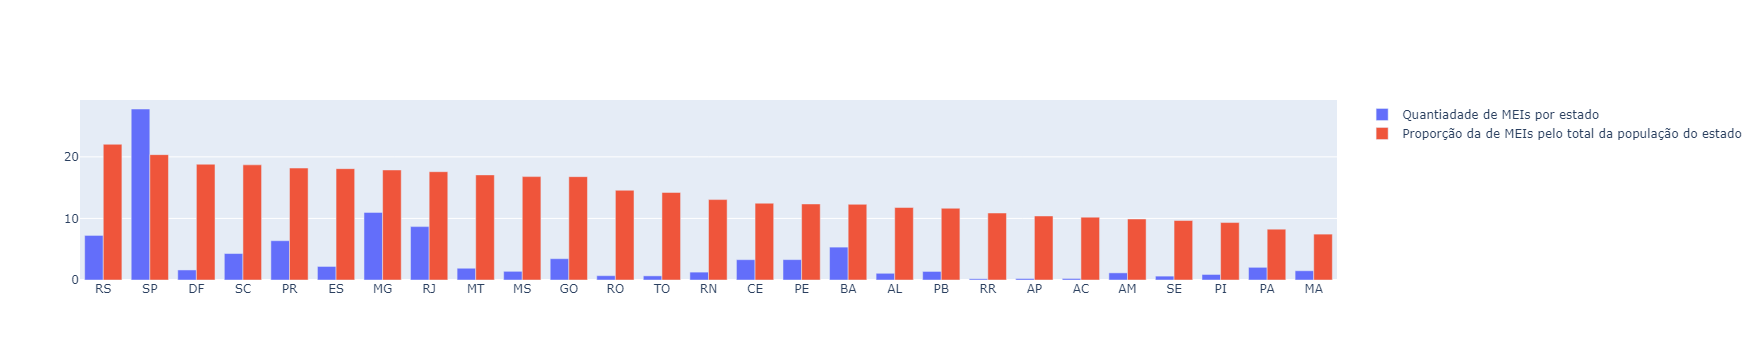

'https://plotly.com/~mateusmoraesalmeida/46/'

In [85]:
fig = go.Figure(data=[
    go.Bar(name='Quantiadade de MEIs por estado', x=df_join_pop.UF, y=df_join_pop.pcnt_base),
    go.Bar(name='Proporção da de MEIs pelo total da população do estado', x=df_join_pop.UF, y=df_join_pop.proporcao)
])

fig.show()
py.plot(fig, filename = 'proporcao_pop_meis', auto_open=True)

In [74]:
df_uf['pcnt_base'] = ((df_uf['count']/33734992)*100).round(2)

C:\Users\pedro\AppData\Local\Temp\ipykernel_27652\2705818083.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



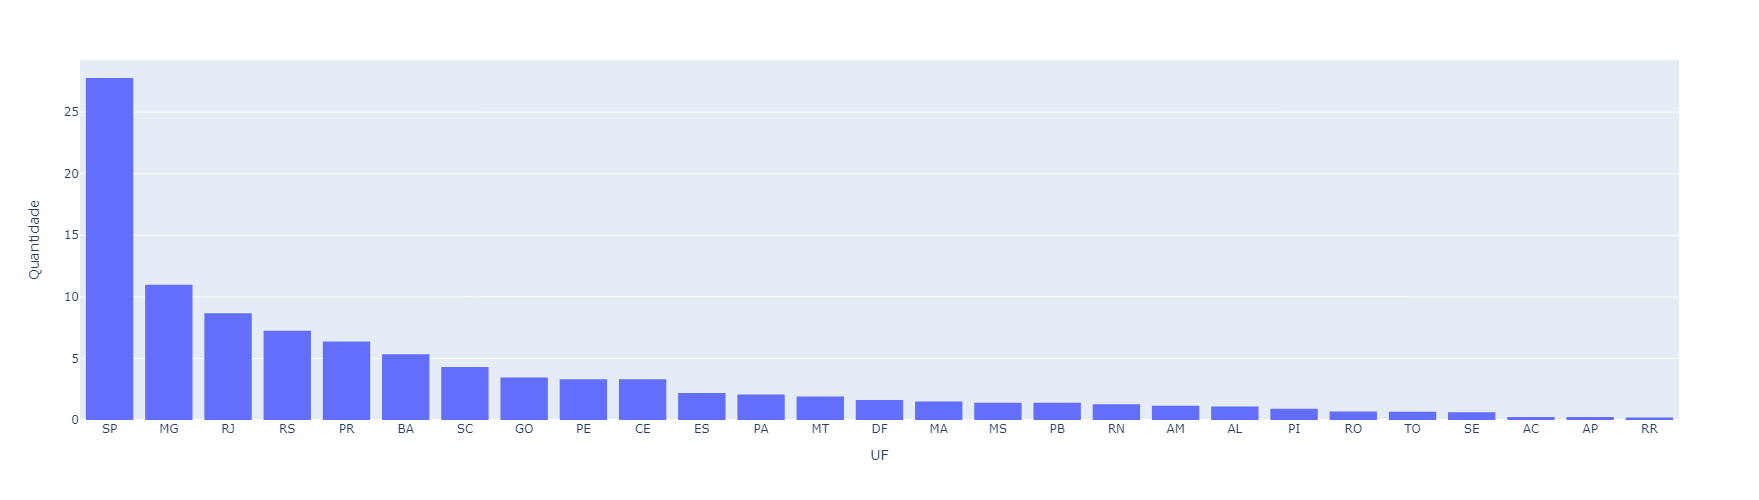

In [69]:
fig = px.histogram(df_uf,
             x = "UF", 
             y='count',
             height = 500, width = 960,
             histnorm = 'percent')
fig.update_xaxes(title = "UF")
fig.update_yaxes(title = "Quantidade")
#fig.show()
#py.plot(fig, filename = 'Count pnt', auto_open=True)

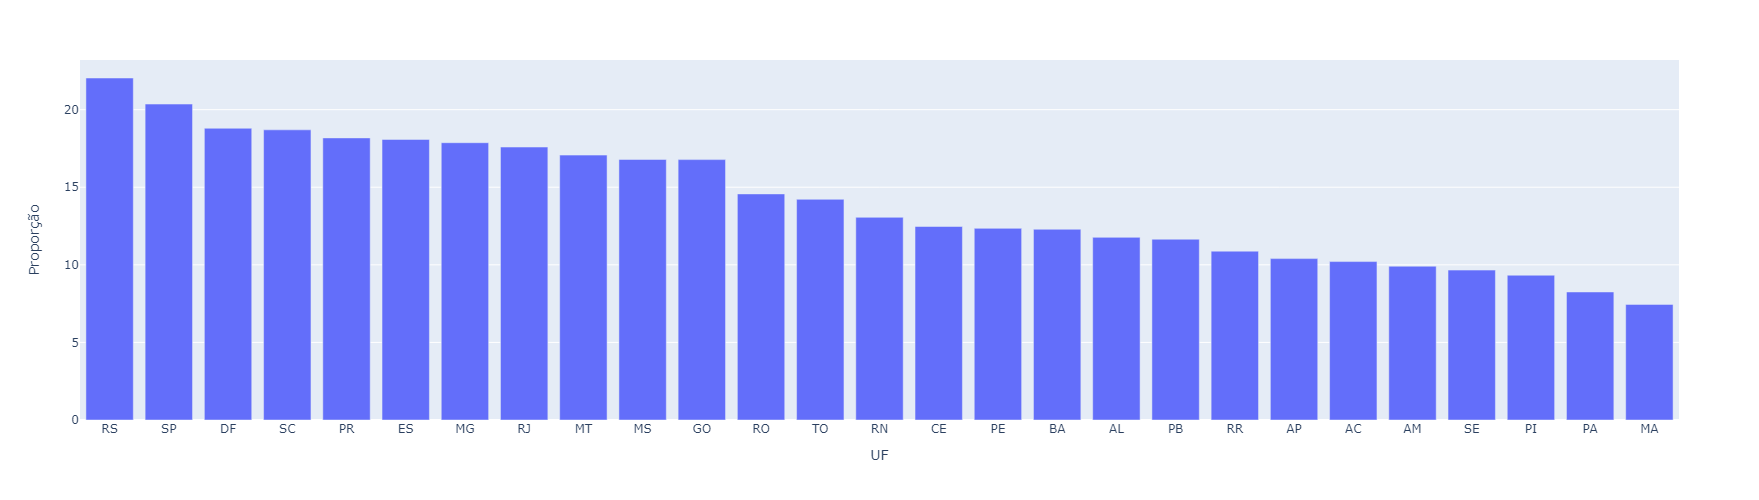

'https://plotly.com/~mateusmoraesalmeida/46/'

In [67]:
fig = px.bar(df_join_pop,
             x = "UF", 
             y='proporcao',
             height = 500, width = 960)
fig.update_xaxes(title = "UF")
fig.update_yaxes(title = "Proporção")
fig.show()
py.plot(fig, filename = 'proporcao_pop_meis', auto_open=True)

In [92]:
d = {'jan': [2.91,10.34], 
'fev': [7.62, 6.68], 
'mar': [3.77, 7.96], 
'abr': [4.62, 8.93], 
'mai': [5.42,  9.2], 
'jun': [6.35, 5.25], 
'jul': [2.22, 11.43], 
'ago': [8.2, 12.9], 
'set': [9.1, 13.3], 
'out': [10.23, 14.52], 
'nov': [11.35, 15.22], 
'dez': [13.24, 16.93]}
df = pd.DataFrame(data=d)
df

,jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez
0,2.91,7.62,3.77,4.62,5.42,6.35,2.22,8.2,9.1,10.23,11.35,13.24
1,10.34,6.68,7.96,8.93,9.20,5.25,11.43,12.9,13.3,14.52,15.22,16.93


In [95]:
df.transpose().describe()

,0,1
count,12.000000,12.000000
mean,7.085833,11.055000
std,3.477613,3.609826
min,2.220000,5.250000
25%,4.407500,8.687500
50%,6.985000,10.885000
75%,9.382500,13.605000
max,13.240000,16.930000


In [94]:
df.transpose().sum()/12

0     7.085833
1    11.055000
dtype: float64

In [100]:
37/38

0.9736842105263158

In [101]:
796+77+77

950

In [98]:
873/905

0.9646408839779006

In [99]:
41/45

0.9111111111111111